# Monte Carlo Methods

In this notebook, we will implement many Monte Carlo (MC) algorithms. 

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [2]:
env = gym.make("Blackjack-v1")

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [5]:
num_times = 3

for _ in range(num_times):
    state = env.reset()
    while True:
        action = env.action_space.sample()
        print(state, action)
        state, reward, done, _, _ = env.step(action)
        if done:
            print("End game! Reward: ", reward)
            print("You won :)\n") if reward > 0 else print("You lost :(\n")
            break

((12, 5, False), {}) 1
(13, 5, False) 1
End game! Reward:  -1.0
You lost :(

((15, 2, False), {}) 1
End game! Reward:  -1.0
You lost :(

((11, 3, False), {}) 0
End game! Reward:  1.0
You won :)



### Part 1: MC Prediction

In this section, we will implement MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [6]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()[0]
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, _, _ = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [7]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((18, 5, False), np.int64(1), -1.0)]
[((20, 5, False), np.int64(1), -1.0)]
[((16, 9, False), np.int64(1), -1.0)]


Let's implement first, first-visit and then every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

**Algorithm:** First-Visit MC Prediction (*for state values*)

**Input:** policy $ \pi $, positive integer $ \text{num\_episodes} $  
**Output:** value function $ V \approx v_{\pi} $ if $ \text{num\_episodes} $ is large enough  

1. Initialize $ N(s) = 0 $ for all $ s \in S $  
2. Initialize $ \text{returns\_sum}(s) = 0 $ for all $ s \in S $  
3. **for** $ i \leftarrow 1 $ **to** $ \text{num\_episodes} $ **do**  
   1. Generate an episode $ S_0, A_0, R_1, \ldots, S_T $ using $ \pi $  
   2. **for** $ t \leftarrow 0 $ **to** $ T - 1 $ **do**  
      1. **if** $ S_t $ is a first visit (with return $ G_t $) **then**  
         1. $ N(S_t) \leftarrow N(S_t) + 1 $  
         2. $ \text{returns\_sum}(S_t) \leftarrow \text{returns\_sum}(S_t) + G_t $  
4. **end for**  
5. $ V(s) \leftarrow \text{returns\_sum}(s) / N(s) $ for all $ s \in S $  
6. **return** $ V $  


In [8]:
def mc_prediction_firstvisit_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode
        episode = generate_episode(env)

        # Initialize an empty list to keep track of visited (state, action) pairs
        visited_state_action_pairs = set()

        # Loop over each step in the episode
        for t, (state, action, reward) in enumerate(episode):
            # Check if it's the first visit of this (state, action) pair in the episode
            if (state, action) not in visited_state_action_pairs:
                visited_state_action_pairs.add((state, action))

                # Calculate the return Gt
                Gt = sum(
                    [gamma**i * episode[t + i][2] for i in range(len(episode) - t)]
                )

                # Update running sum of returns and count of visits
                returns_sum[state][action] += Gt
                N[state][action] += 1.0

                # Calculate new Q-value
                Q[state][action] = returns_sum[state][action] / N[state][action]
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

Episode 500000/500000.

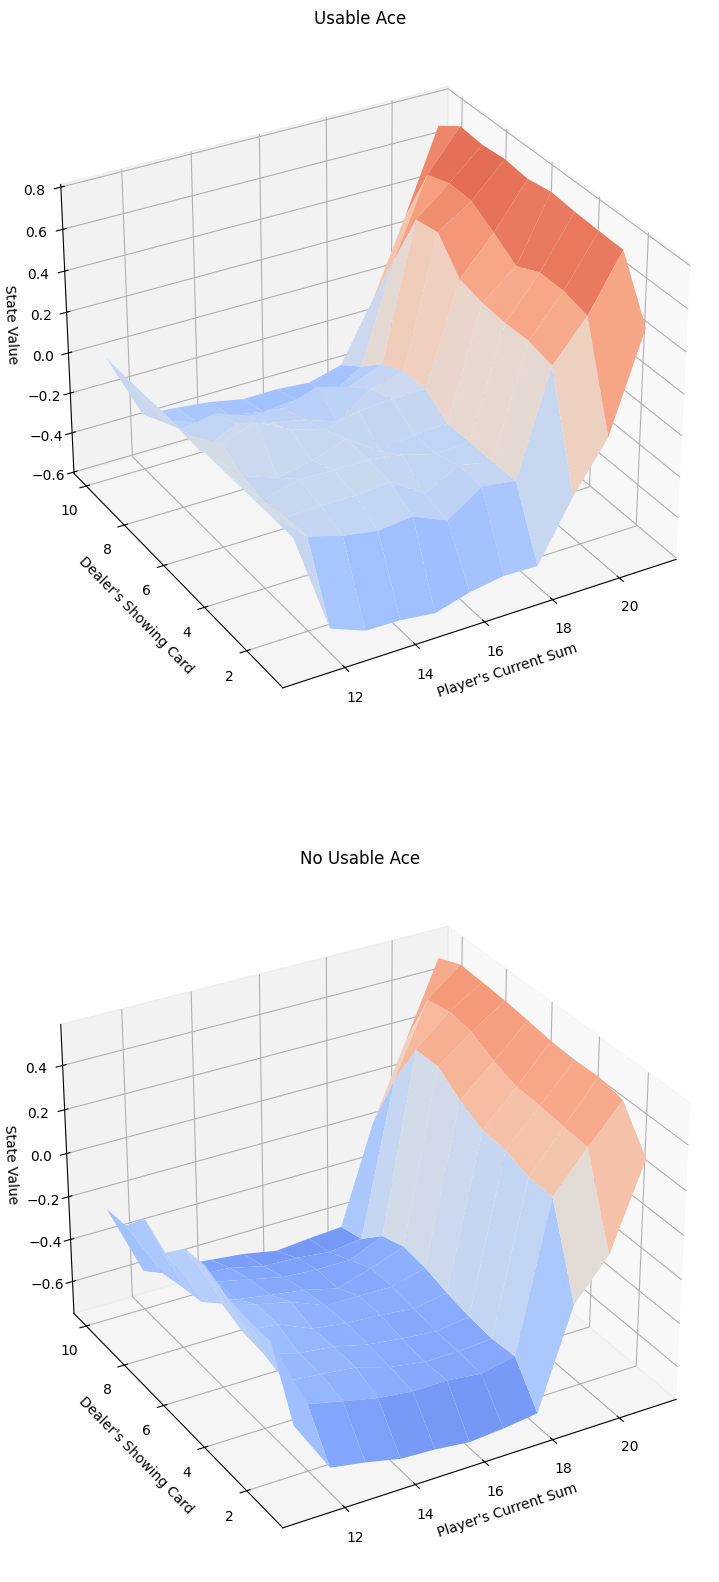

In [9]:
# obtain the action-value function
Q = mc_prediction_firstvisit_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict(
    (k, (k[0] > 18) * (np.dot([0.8, 0.2], v)) + (k[0] <= 18) * (np.dot([0.2, 0.8], v)))
    for k, v in Q.items()
)

# plot the state-value function
plot_blackjack_values(V_to_plot)

**Algorithm:** Every-Visit MC Prediction (*for state values*)

**Input:** policy $ \pi $, positive integer $ \text{num\_episodes} $  
**Output:** value function $ V \approx v_{\pi} $ if $ \text{num\_episodes} $ is large enough  

1. Initialize $ N(s) = 0 $ for all $ s \in S $  
2. Initialize $ \text{returns\_sum}(s) = 0 $ for all $ s \in S $  
3. **for** $ i \leftarrow 1 $ **to** $ \text{num\_episodes} $ **do**  
   1. Generate an episode $ S_0, A_0, R_1, S_1, A_1, R_2, \ldots, S_T $ using $ \pi $  
   2. **for** $ t \leftarrow 0 $ **to** $ T - 1 $ **do**  
      1. Calculate the return $ G_t $ from step $ t $:
         - $ G_t = \sum_{k=0}^{T-t} \gamma^k \cdot R_{t+k+1} $  
      2. Increment $ N(S_t) \leftarrow N(S_t) + 1 $  
      3. Update $ \text{returns\_sum}(S_t) \leftarrow \text{returns\_sum}(S_t) + G_t $  
4. **end for**  
5. $ V(s) \leftarrow \text{returns\_sum}(s) / N(s) $ for all $ s \in S $  
6. **return** $ V $  


In [10]:
def mc_prediction_everyvisit_q(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries for returns sums and visit counts
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # Monitor progress
        if i_episode % 1000 == 0:
            print(f"Episode {i_episode}/{num_episodes}", end="\r")

        # Generate an episode using the provided generate_episode function
        episode = generate_episode(env)

        # Loop over each step in the episode
        for t, (state, action, reward) in enumerate(episode):
            # Calculate the return G_t from this step onward
            G_t = sum([gamma**i * episode[t + i][2] for i in range(len(episode) - t)])

            # Update returns_sum and N for every visit to (state, action) pair
            returns_sum[state][action] += G_t
            N[state][action] += 1

            # Update the Q-value for (state, action) pair
            Q[state][action] = returns_sum[state][action] / N[state][action]

    return Q

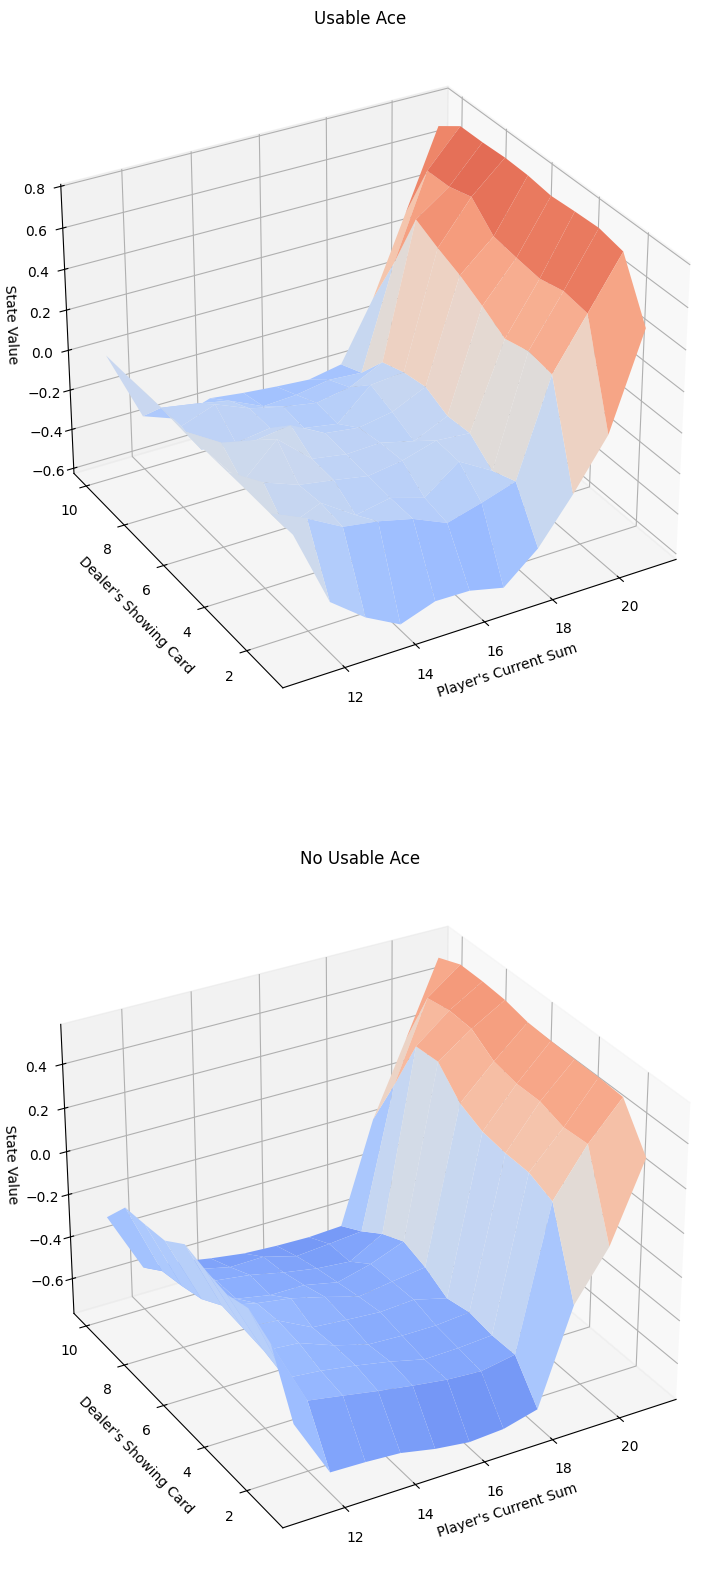

In [11]:
# obtain the action-value function
Q = mc_prediction_everyvisit_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict(
    (k, (k[0] > 18) * (np.dot([0.8, 0.2], v)) + (k[0] <= 18) * (np.dot([0.2, 0.8], v)))
    for k, v in Q.items()
)

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, we will implementat constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

**Algorithm:** First-Visit Constant-α (GLIE) MC Control

**Input:** positive integer $ \text{num\_episodes} $, small positive fraction $ \alpha $, GLIE $ \{ \epsilon_i \} $  
**Output:** policy $ \pi \approx \pi_* $ if $ \text{num\_episodes} $ is large enough  

1. Initialize $ Q(s, a) $ arbitrarily (e.g., $ Q(s, a) = 0 $ for all $ s \in S $ and $ a \in A(s) $)  
2. **for** $ i \leftarrow 1 $ **to** $ \text{num\_episodes} $ **do**  
   1. $ \epsilon \leftarrow \epsilon_i $  
   2. $ \pi \leftarrow \epsilon $-greedy($ Q $)  
   3. Generate an episode $ S_0, A_0, R_1, \ldots, S_T $ using $ \pi $  
   4. **for** $ t \leftarrow 0 $ **to** $ T - 1 $ **do**  
      1. **if** $ (S_t, A_t) $ is a first visit (with return $ G_t $) **then**  
         - $ Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha (G_t - Q(S_t, A_t)) $  
5. **end for**  
6. **return** $ \pi $  

In [12]:
def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n  # Number of actions
    # Initialize Q table with zeros
    Q = defaultdict(lambda: np.zeros(nA))

    # GLIE: epsilon decays over episodes
    def epsilon_greedy_policy(state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.choice(nA)  # Random action (exploration)
        else:
            return np.argmax(Q[state])  # Best action (exploitation)

    # Loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # Monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Decay epsilon as episodes progress
        epsilon = max(
            0.05, 1.0 / (0.001 * i_episode + 1)
        )  # Slower decay for sufficient exploration

        # Generate an episode
        episode = []
        state = env.reset()[0]
        done = False

        while not done:
            action = epsilon_greedy_policy(state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        # Track visited state-action pairs to apply first-visit MC
        visited_state_action_pairs = set()

        # Loop over each step in the episode
        for t, (state, action, reward) in enumerate(episode):
            # Check if it is the first visit to (state, action)
            if (state, action) not in visited_state_action_pairs:
                visited_state_action_pairs.add((state, action))

                # Calculate return G_t from step t onwards
                G_t = sum(
                    [gamma**i * episode[t + i][2] for i in range(len(episode) - t)]
                )

                # Update Q-value using constant step-size alpha
                Q[state][action] = Q[state][action] + alpha * (G_t - Q[state][action])

    # Derive policy from Q using the best action at each state
    policy = {state: np.argmax(actions) for state, actions in Q.items()}

    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

Here are some recommended values for `alpha` and `gamma`, based on common practices and the characteristics of Blackjack:

### Recommended Values

1. **Gamma (Discount Factor)**
   - **Suggested Value**: `gamma = 1.0`
   - **Reason**: In Blackjack, the outcome (win, lose, or draw) is only determined at the end of the episode. Since there are no intermediate rewards to consider, setting `gamma = 1.0` makes sense because we care about the total cumulative reward at the end rather than discounting future rewards. This will emphasize long-term returns, which is appropriate for episodic games like Blackjack.

2. **Alpha (Learning Rate)**
   - **Suggested Range**: `alpha = 0.01` to `0.1`
   - **Typical Value**: `alpha = 0.05`
   - **Reason**: A smaller learning rate (e.g., `0.05`) is often beneficial in Monte Carlo methods because it allows for gradual convergence without large oscillations in Q-values. Since Blackjack has a lot of variance in returns, a smaller `alpha` will help smooth out the learning process. 

### Explanation of Suggested Values

- **Gamma = 1.0**: This value ensures that the algorithm places full weight on future rewards within each episode. Since Blackjack only has a final reward, this setup will focus on the end result of each episode without prematurely discounting any returns.
  
- **Alpha between 0.01 and 0.1**: A lower `alpha` allows the Q-values to converge more smoothly, especially given the high variance in rewards in Blackjack. If you use a very high `alpha` (e.g., `0.5`), Q-values can fluctuate significantly with each episode, leading to an unstable policy. A moderate value, like `0.05`, provides a good balance between learning speed and stability.

In [13]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, num_episodes=5_000_000, alpha=0.01, gamma=1.0)

Episode 5000000/5000000.

Next, we plot the corresponding state-value function.

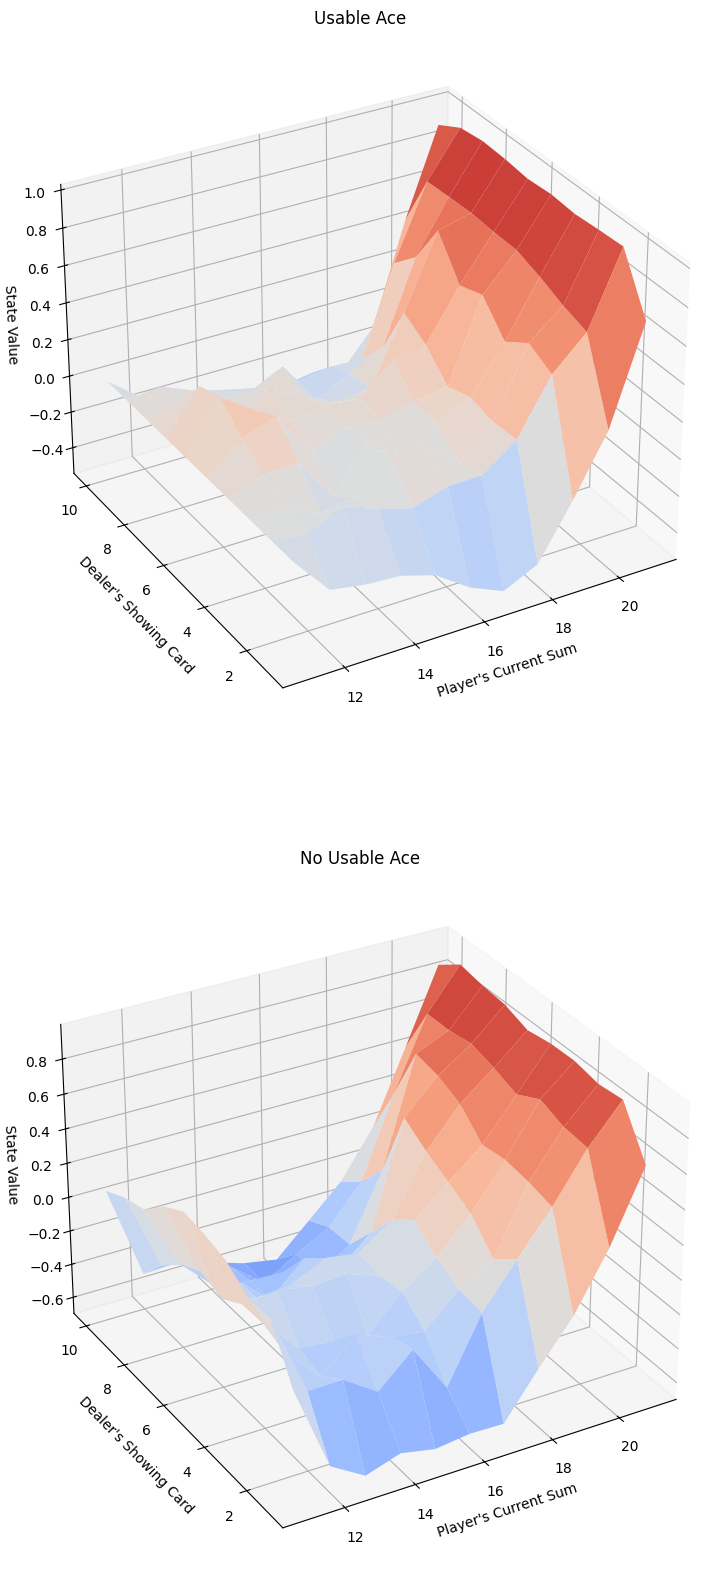

In [14]:
# obtain the corresponding state-value function
V = dict((k, np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

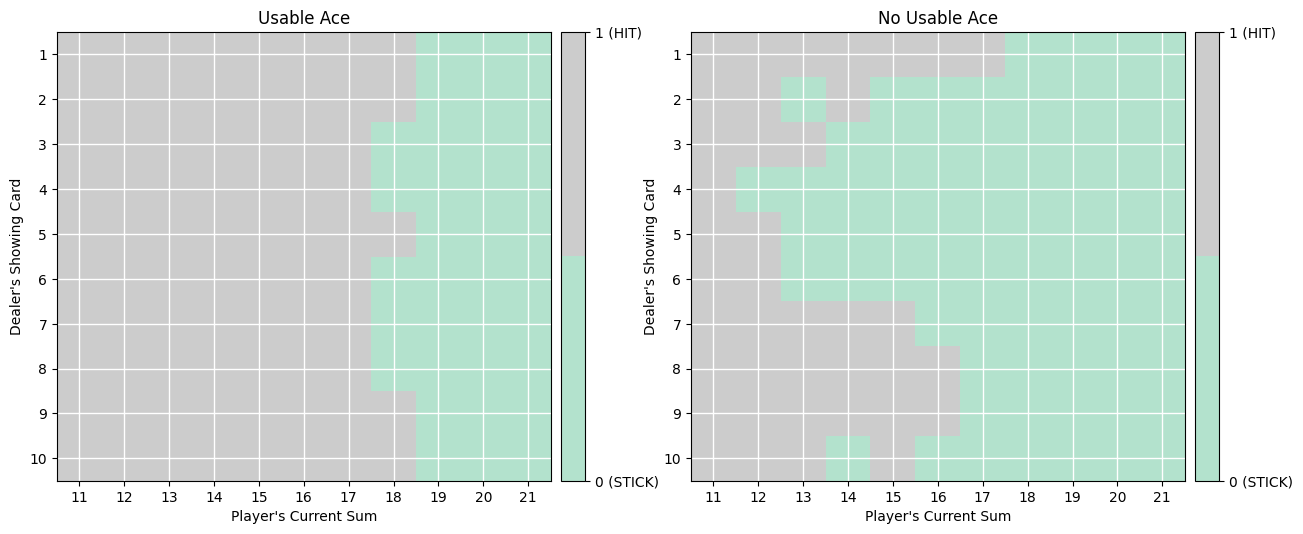

In [15]:
# plot the policy
plot_policy(policy)

### Testing the Policy

In [16]:
def test_policy(env, policy, num_episodes=10_000):
    total_rewards = 0
    wins = 0
    losses = 0
    draws = 0

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Get the action from the policy
            action = policy.get(
                state[0], 0
            )  # Use action 0 (stick) as a default if state is not in policy

            # Take the action in the environment
            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            state = next_state

        # Update the counters based on the outcome
        total_rewards += episode_reward
        if episode_reward > 0:
            wins += 1
        elif episode_reward < 0:
            losses += 1
        else:
            draws += 1

    # Calculate average reward per episode
    avg_reward = total_rewards / num_episodes

    print(f"After {num_episodes} episodes:")
    print(f"Average Reward per Episode: {avg_reward:.2f}")
    print(f"Wins: {wins}, Losses: {losses}, Draws: {draws}")
    print(f"Win Rate: {wins / num_episodes * 100:.2f}%")
    print(f"Loss Rate: {losses / num_episodes * 100:.2f}%")
    print(f"Draw Rate: {draws / num_episodes * 100:.2f}%")


# Test the policy learned by the Monte Carlo control function
test_policy(env, policy)

After 10000 episodes:
Average Reward per Episode: -0.08
Wins: 4228, Losses: 5044, Draws: 728
Win Rate: 42.28%
Loss Rate: 50.44%
Draw Rate: 7.28%
